# Mandelon

MADELON is an artificial dataset containing data points grouped in 32 clusters placed on the vertices of a five dimensional hypercube and randomly labeled +1 or -1. The five dimensions constitute 5 informative features. 15 linear combinations of those features were added to form a set of 20 (redundant) informative features. Based on those 20 features one must separate the examples into the 2 classes (corresponding to the +-1 labels). We added a number of distractor feature called 'probes' having no predictive power. The order of the features and patterns were randomized.


Sources:
- https://github.com/dstrodtman/madelon

## Importamos librerías

In [2]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm
from deap import base  # Estructura que permite agrupar todos los componentes de nuestro algoritmo en una misma bolsa
from deap import creator  # Permite crear los componentes de nuestro algoritmo
from deap import tools  # Contiene funciones precargadas
from joblib import Parallel, delayed
from scipy.io import arff
scaler = StandardScaler()

In [3]:
tra, trameta = arff.loadarff('/home/sebacastillo/ealab/data/madelon.trn.arff')
tst, tstmeta = arff.loadarff('/home/sebacastillo/ealab/data/madelon.tst.arff')
train = pl.DataFrame(tra)


In [4]:
train.head(3)

att_1,att_2,att_3,att_4,att_5,att_6,att_7,att_8,att_9,att_10,att_11,att_12,att_13,att_14,att_15,att_16,att_17,att_18,att_19,att_20,att_21,att_22,att_23,att_24,att_25,att_26,att_27,att_28,att_29,att_30,att_31,att_32,att_33,att_34,att_35,att_36,att_37,…,att_465,att_466,att_467,att_468,att_469,att_470,att_471,att_472,att_473,att_474,att_475,att_476,att_477,att_478,att_479,att_480,att_481,att_482,att_483,att_484,att_485,att_486,att_487,att_488,att_489,att_490,att_491,att_492,att_493,att_494,att_495,att_496,att_497,att_498,att_499,att_500,class
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,binary
485.0,477.0,537.0,479.0,452.0,471.0,491.0,476.0,475.0,473.0,455.0,500.0,456.0,507.0,478.0,491.0,447.0,422.0,480.0,482.0,515.0,482.0,464.0,484.0,477.0,496.0,509.0,491.0,459.0,482.0,483.0,505.0,508.0,458.0,509.0,517.0,479.0,…,462.0,498.0,480.0,511.0,500.0,437.0,537.0,470.0,515.0,476.0,467.0,401.0,485.0,499.0,495.0,490.0,508.0,463.0,487.0,531.0,515.0,476.0,482.0,463.0,467.0,479.0,477.0,481.0,477.0,485.0,511.0,485.0,481.0,479.0,475.0,496.0,[binary data]
483.0,458.0,460.0,487.0,587.0,475.0,526.0,479.0,485.0,469.0,434.0,483.0,465.0,503.0,472.0,478.0,469.0,518.0,495.0,491.0,478.0,530.0,462.0,494.0,549.0,469.0,516.0,487.0,475.0,486.0,478.0,514.0,542.0,406.0,469.0,452.0,483.0,…,500.0,487.0,476.0,526.0,449.0,363.0,466.0,478.0,465.0,479.0,482.0,549.0,470.0,506.0,481.0,494.0,492.0,448.0,492.0,447.0,598.0,507.0,478.0,483.0,492.0,485.0,463.0,478.0,487.0,338.0,513.0,486.0,483.0,492.0,510.0,517.0,[binary data]
487.0,542.0,499.0,468.0,448.0,471.0,442.0,478.0,480.0,477.0,468.0,497.0,477.0,491.0,493.0,502.0,465.0,567.0,510.0,475.0,474.0,483.0,490.0,492.0,544.0,482.0,454.0,496.0,491.0,495.0,476.0,438.0,489.0,432.0,486.0,512.0,475.0,…,509.0,492.0,487.0,524.0,479.0,441.0,529.0,481.0,485.0,478.0,479.0,454.0,503.0,501.0,500.0,484.0,479.0,470.0,466.0,529.0,482.0,486.0,487.0,480.0,522.0,481.0,487.0,481.0,492.0,650.0,506.0,501.0,480.0,489.0,499.0,498.0,[binary data]


In [5]:
train = (
    train.with_columns(
        pl.col('class').cast(pl.datatypes.Utf8)
    )   
)
test =  pl.DataFrame(tst)
test = (
    test.with_columns(
        pl.col('class').cast(pl.datatypes.Utf8)
    )   
)


In [6]:
train.head(1)

att_1,att_2,att_3,att_4,att_5,att_6,att_7,att_8,att_9,att_10,att_11,att_12,att_13,att_14,att_15,att_16,att_17,att_18,att_19,att_20,att_21,att_22,att_23,att_24,att_25,att_26,att_27,att_28,att_29,att_30,att_31,att_32,att_33,att_34,att_35,att_36,att_37,…,att_465,att_466,att_467,att_468,att_469,att_470,att_471,att_472,att_473,att_474,att_475,att_476,att_477,att_478,att_479,att_480,att_481,att_482,att_483,att_484,att_485,att_486,att_487,att_488,att_489,att_490,att_491,att_492,att_493,att_494,att_495,att_496,att_497,att_498,att_499,att_500,class
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
485.0,477.0,537.0,479.0,452.0,471.0,491.0,476.0,475.0,473.0,455.0,500.0,456.0,507.0,478.0,491.0,447.0,422.0,480.0,482.0,515.0,482.0,464.0,484.0,477.0,496.0,509.0,491.0,459.0,482.0,483.0,505.0,508.0,458.0,509.0,517.0,479.0,…,462.0,498.0,480.0,511.0,500.0,437.0,537.0,470.0,515.0,476.0,467.0,401.0,485.0,499.0,495.0,490.0,508.0,463.0,487.0,531.0,515.0,476.0,482.0,463.0,467.0,479.0,477.0,481.0,477.0,485.0,511.0,485.0,481.0,479.0,475.0,496.0,"""-1"""


In [7]:
train.groupby('class').agg(pl.count())

class,count
str,u32
"""-1""",1000
"""1""",1000


In [8]:
print(train.shape), print(test.shape)

(2000, 501)
(600, 501)


(None, None)

# PARTICIONO LOS DATOS

# Leemos los datasets

In [9]:
TRAIN = train
TEST = test

# Normalizamos los datos

In [10]:

TRAIN = TRAIN.to_numpy()
TEST = TEST.to_numpy()

X_TRAIN = TRAIN[:,:-1]
y_train = TRAIN[:,-1]
y_train = np.where(np.array(y_train) == '1', 1, 0).astype('int64')
X_TEST = TEST[:,:-1]
y_test = TEST[:,-1]
y_test = np.where(np.array(y_test) == '1', 1, 0).astype('int64')
scaler.fit(X_TRAIN)
Xtrain = scaler.transform(X_TRAIN)
Xtest = scaler.transform(X_TEST)


In [11]:
print(y_train)
print(y_test)

[0 0 0 ... 0 1 1]
[0 0 0 1 0 1 0 0 0 1 1 1 0 1 1 0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 0 1 0 1
 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 0 1 1 0 1 0 0 0 1 0 1 1 1 1 0 1 0 0 1 0 1 1
 1 0 1 0 1 0 1 0 0 1 1 1 1 1 1 1 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 1 0 0 1 1 1
 0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 1 1 0 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0
 0 0 1 0 1 0 0 1 1 1 1 0 1 1 0 0 0 0 1 1 0 1 1 1 0 0 0 0 1 0 1 0 1 0 1 0 0
 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1 1 0 0 1 0 0 0 1 1 0 0 1 1
 0 0 1 0 0 0 0 1 0 0 1 1 1 1 0 0 0 1 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 1
 1 1 1 1 0 1 1 0 0 1 0 1 1 0 0 0 0 1 1 1 1 1 0 1 1 1 0 0 1 1 0 0 0 1 1 1 1
 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 1 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 1
 1 0 1 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 0 1 1
 0 0 0 0 1 1 1 1 0 1 0 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 1 1 0 0
 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 1 1 0 0 1 0 1 0
 0 1 1 1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 1 1 0 1 0 1 1
 1 1 1 

## Funciones auxiliares

In [12]:
#=================================
def bin(p=0.9):
    '''
    Esta función genera un bit al azar.
    '''
    if random.random() < p:
        return 1
    else:
        return 0
#=================================


#=================================
def fitness(features, Xtrain, Xtest, y_train, y_test):
    '''
    Función de aptitud empleada por nuestro algoritmo.
    '''
    if not isinstance(features, np.ndarray):
        features = np.array(features)

    if not isinstance(features[0], bool):
        features = features.astype(bool)
    
    X_train = Xtrain[:,features]
    X_test = Xtest[:,features]
    
    mlp = MLPClassifier(hidden_layer_sizes=(5,3),
                        activation='tanh',
                        solver='adam',
                        alpha=0.0001,
                        learning_rate_init=0.001,
                        shuffle=True,
                        momentum=0.9,
                        validation_fraction=0.2,
                        n_iter_no_change=10,
                        random_state=42,
                        max_iter=3000).fit(X_train, y_train)

    yp = mlp.predict(X_test)

    acc = (y_test == yp).sum()/len(y_test)

    n_genes = 1 - (features.sum() / len(features))

    alpha = 0.5
    f = (alpha*acc + (1-alpha)*n_genes)
    
    return f, acc, n_genes
#=================================

    
#=================================
def mutation(ind, p):
    '''
    Esta función recorre el cromosoma y evalúa, para cada gen,
    si debe aplicar el operador de mutación.
    '''
    return [abs(i-1) if random.random() < p else i for i in ind]
#=================================

## Inicializamos parámetros del experimento

In [13]:
IND_SIZE = Xtrain.shape[1]  # Cantidad de genes en el cromosoma

POP_SIZE = 100  # Cantidad de individuos en la población
PM = 20./IND_SIZE  # Probabilidad de mutación [aproximadamente 1 gen por cromosoma]
#                   Experimento 4: con mayor probabilidad de mutación.
# PM = 20./IND_SIZE __experimento 2 mejoró el fitness y acc en la segunda generación pero luego se estancó
PX = 0.75  # Probabilidad de cruza
# PX = 0.85  # Probabilidad de cruza
GMAX = 20  # Cantidad máxima de generaciones que se ejecutará el algoritmo

In [14]:
print(IND_SIZE)
print(POP_SIZE)
print(PM)
print(PX)
print(GMAX)

500
100
0.04
0.75
20


## Creamos los componentes del algoritmo

**Documentación**: https://deap.readthedocs.io/en/master/api/creator.html

In [15]:
# CREAMOS LA FUNCION DE FITNESS
# Esta función tiene "1 OBJETIVO" a "MAXIMIZAR"
creator.create("Fitness",  # Nombre con el que se registra el componente
               base.Fitness,  # Clase de la que hereda
               weights=(1.0,)) 

#---------------------

# CREAMOS EL CONSTRUCTOR DE INDIVIDUOS
creator.create("Individual", # Nombre con el que se registra el componente
               list,  # Clase de la que hereda [Tipo de contenedor en este caso]
               fitness=creator.Fitness,
               acc=0,
               ngenes=0)  # Asignamos un método para evaluar el fitness del individuo

## REGISTRAMOS COMPONENTES

In [16]:
toolbox = base.Toolbox()

#---------------------

# DEFINIMOS COMO CONSTRUIR UN GEN
# el algoritmo retenie la historia de fitnes de genes activos, contribuyendo !!!IMPORTANTE
# a la selección de las variables que contribuyen a mejorar el fitness
toolbox.register("attribute",  # Nombre con el que se registra el componente
                 bin,
                 p=0.1)
                        # Probabilidad de un "1":   exp1:0.1 =ELITE -- Fitness: 0.9513 -- NGENES: 694 -- Acc: 1.0
                        #                           exp2:0.2 =ELITE -- Fitness: 0.8885 -- NGENES: 1380 -- Acc: 0.9706
                        #                           exp3:0.05=ELITE -- Fitness: 0.9595 -- NGENES: 368 -- Acc: 0.9706
                     #                              exp5:0.05 + 20/caracteristicas mutacion: ELITE -- Fitness: 0.9757 -- NGENES: 346 -- Acc: 1.0
#---------------------

# DEFINIMOS COMO CONSTRUIR UN INDIVIDUO/CROMOSOMA
toolbox.register("individual",  # Nombre con el que se registra el componente
                 tools.initRepeat,  # Método usado para construir el cromosoma
                 creator.Individual,  # ...
                 toolbox.attribute,  # Función para construir cada gen
                 n=IND_SIZE)  # Número de genes del cromosoma/individuo (se repetirá la función construir gen)

#---------------------

# DEFINIMOS COMO CONSTRUIR LA POBLACION
toolbox.register("population",  # Nombre con el que se registra el componente
                 tools.initRepeat,  # Método usado para construir el cromosoma
                 list,
                 toolbox.individual)

#---------------------

# DEFINIMOS COMO REALIZAR LA CRUZA
toolbox.register("mate",  # Nombre con el que se registra el componente
                 tools.cxTwoPoint)  # 

#---------------------

# DEFINIMOS COMO REALIZAR LA MUTACION
toolbox.register("mutate",  # Nombre con el que se registra el componente
                 mutation,  # Método de mutación (definido como función más arriba)
                 p=PM)  # Parámetro que usa la mutación

#toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
#toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)

#---------------------

# DEFINIMOS COMO REALIZAR LA SELECCION DE INDIVIDUOS
toolbox.register("select",  # Nombre con el que se registra el componente
                 tools.selTournament,  # Método usado para selección [selRoulette | selTournament | ...]
                 tournsize=5)  # Parámetro que usa el torneo

## Definimos las estadísticas a calcular

In [17]:
# EXTRAEMOS EL FITNESS DE TODOS LOS INDIVIDUOS
stats_fit = tools.Statistics(key=lambda ind: ind.fitness.values[0])

# EXTRAEMOS EL ACC DE TODOS LOS INDIVIDUOS
stats_acc = tools.Statistics(key=lambda ind: ind.acc)

# EXTRAEMOS LA FRACCION DE GENES ACTIVOS DE TODOS LOS INDIVIDUOS
stats_frac_active_genes = tools.Statistics(key=lambda ind: ind.ngenes)

# EXTRAEMOS EL NUMERO DE GENES ACTIVOS DE TODOS LOS INDIVIDUOS
stats_active_genes = tools.Statistics(key=lambda ind: np.sum(ind))

mstats = tools.MultiStatistics(fitness=stats_fit,
                               acc=stats_acc,
                               frac_ngenes=stats_frac_active_genes,
                               ngenes=stats_active_genes)

mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

# INICIALIZAMOS UN LOGGER
logbook = tools.Logbook()

# Corremos el modelo con todas las features

In [18]:
f = fitness(np.ones(Xtrain.shape[1]), Xtrain, Xtest, y_train, y_test)

print(f'FITNESS: {f[0]:.4} -- NGENES: {int(Xtrain.shape[1])} -- Acc: {f[1]:.4}\n')

FITNESS: 0.2667 -- NGENES: 500 -- Acc: 0.5333



In [19]:
#================================================
# INICIALIZAMOS LA POBLACIÓN
#================================================
pop = toolbox.population(n=POP_SIZE)  # Inicializamos una población
#================================================


#================================================
# EVALUAMOS EL FITNESS DE LA POBLACION
#======================================
#fitnesses = list(map(toolbox.evaluate, pop))
fitnesses = Parallel(n_jobs=4, backend='multiprocessing')(delayed(fitness)(ind, Xtrain, Xtest, y_train, y_test) for ind in pop)
#================================================


#================================================
# ASIGNAMOS A CADA INDIVIDUO SU FITNESS
#========================================
for ind,fit in zip(pop, fitnesses):
    ind.fitness.values = (fit[0],)  # Guardamos el fitness para cada individuo (en el individuo)
    ind.acc = fit[1]
    ind.ngenes = fit[2]
#================================================

records = mstats.compile(pop)
logbook.record(gen=0, **records)

In [20]:
#################################################################################
# COMENZAMOS LA EVOLUCION
################################

for g in range(1,GMAX):#tqdm(range(GMAX)):

    #================================================
    # SELECCIONAMOS INDIVIDUO ELITE
    #================================
    idx_elite = np.argmax(fitnesses, axis=0)[0]  # Si maximizamos, hay que usar ".argmax()". El indiv. con mejor fitness
    elite = toolbox.clone(pop[idx_elite])
    del elite.fitness.values, elite.acc, elite.ngenes
    #================================================

    
    #================================================
    # HACEMOS UNA COPIA DE LA POBLACION ACTUAL
    #==========================================
    parents = toolbox.select(pop, POP_SIZE)  # Seleccionamos individuos para alcanzar
                                               # el tamaño de la población
    
    offspring = list(map(toolbox.clone, pop))  # Clonamos para tener nuevos individuos
                                                     # (contenedores independientes)
    #============================================
    
    # REALIZAMOS LA CRUZA DE LOS PADRES
    #====================================
    for i in range(POP_SIZE//2):
        parent1 = toolbox.clone(parents[random.randint(0,POP_SIZE-1)])
        parent2 = toolbox.clone(parents[random.randint(0,POP_SIZE-1)])
        
        if random.random() < PX:
            childs = toolbox.mate(parent1, parent2)
        else:
            childs = (parent1, parent2)
        
        offspring[2*i] = childs[0]
        offspring[2*i+1] = childs[1]


    #================================================
    # MUTAMOS LOS HIJOS
    #=================================
    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values  #, mutant.acc, mutant.ngenes
    #================================================
    
    
    #================================================
    # EVALUAMOS EL FITNESS
    # Y SE LO ASIGNAMOS A CADA INDIVIDUO
    #======================================
    offspring[0] = elite
    
    fitnesses = Parallel(n_jobs=4, backend='multiprocessing')(delayed(fitness)(ind, Xtrain, Xtest, y_train, y_test) for ind in offspring)

    for ind, fit in zip(offspring, fitnesses):
        ind.fitness.values = (fit[0],)  # Guardamos el fitness para cada individuo (en el individuo)
        ind.acc = fit[1]
        ind.ngenes = fit[2]
    #================================================

    
    #================================================
    # CONSTRUIMOS LA NUEVA POBLACION
    #================================
    pop = toolbox.clone(offspring)
    #================================================

    
    #================================================
    # CALCULAMOS ESTADÏSTICAS
    #============================
    records = mstats.compile(pop)
    logbook.record(gen=g, **records)

    if (g%1 == 0):
        print('='*79)
        print(f'GENERATION: {g}')
        print(f'ELITE -- Fitness: {elite.fitness.values[0]:.4} -- NGENES: {np.sum(elite)} -- Acc: {elite.acc:.4}')
        print('FITNES: ', records['fitness'])
        print('ACC: ', records['acc'])
        print('GENES: ', records['ngenes'])
    #================================================

GENERATION: 1
ELITE -- Fitness: 0.7552 -- NGENES: 39 -- Acc: 0.5883
FITNES:  {'avg': 0.722065, 'std': 0.014040217927241886, 'min': 0.6848333333333334, 'max': 0.7651666666666667}
ACC:  {'avg': 0.53695, 'std': 0.027535890720617292, 'min': 0.4716666666666667, 'max': 0.6183333333333333}
GENES:  {'avg': 46.41, 'std': 6.04333517190632, 'min': 30, 'max': 60}
GENERATION: 2
ELITE -- Fitness: 0.7652 -- NGENES: 44 -- Acc: 0.6183
FITNES:  {'avg': 0.7354133333333334, 'std': 0.017338660719777518, 'min': 0.7, 'max': 0.7876666666666666}
ACC:  {'avg': 0.5590666666666667, 'std': 0.03182968565488652, 'min': 0.49333333333333335, 'max': 0.6433333333333333}
GENES:  {'avg': 44.12, 'std': 5.042380390252207, 'min': 32, 'max': 60}
GENERATION: 3
ELITE -- Fitness: 0.7877 -- NGENES: 34 -- Acc: 0.6433
FITNES:  {'avg': 0.7520216666666668, 'std': 0.0168945365100345, 'min': 0.7111666666666667, 'max': 0.7876666666666666}
ACC:  {'avg': 0.5869833333333333, 'std': 0.031772363077926004, 'min': 0.49833333333333335, 'max': 0

## Graficamos la evolución del fitness

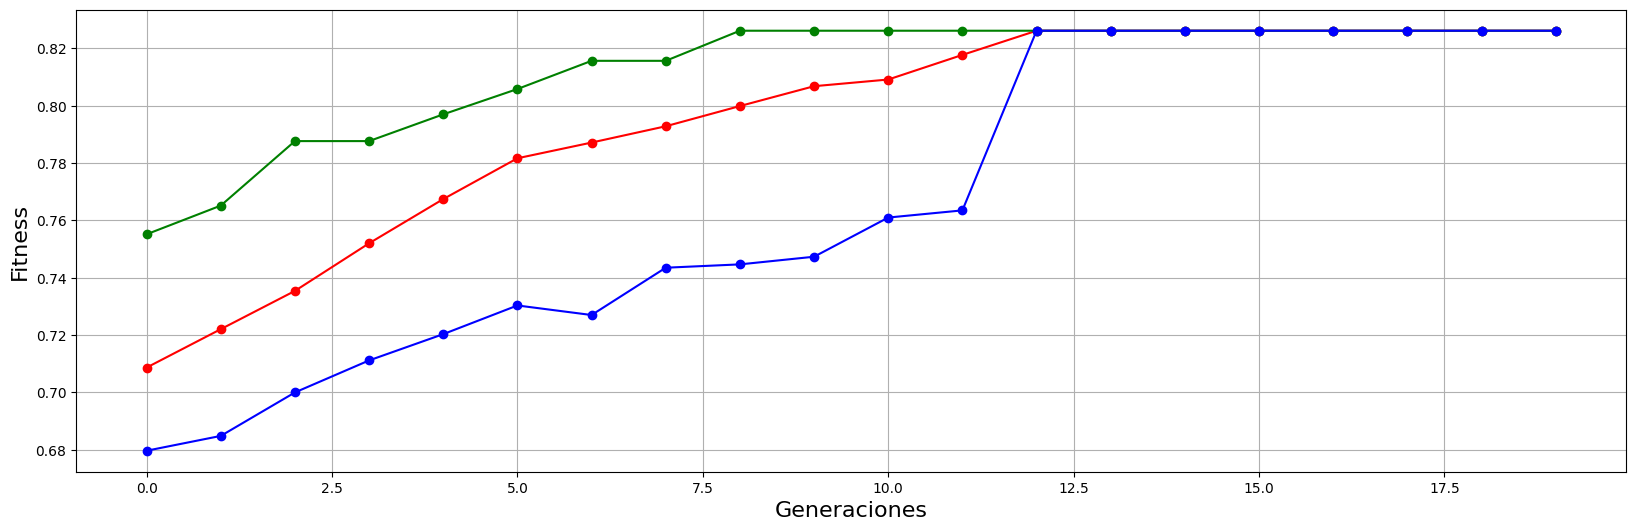

In [21]:
f_avg = logbook.chapters['fitness'].select('avg')  # Extraemos fitness promedio a lo largo de las épocas
f_max = logbook.chapters['fitness'].select('max')  # Extraemos fitness máximo a lo largo de las épocas
f_min = logbook.chapters['fitness'].select('min')  # Extraemos fitness mínimo a lo largo de las épocas

N = 30 if GMAX > 200 else GMAX 
fig, ax = plt.subplots(1, 1, figsize=(20,6)) 
ax.plot(range(N), f_avg[:N], '-or')
ax.plot(range(N), f_max[:N], '-og')
ax.plot(range(N), f_min[:N], '-ob')
ax.set_xlabel('Generaciones', fontsize=16)
ax.set_ylabel('Fitness', fontsize=16)
ax.grid(True)

## Graficamos la evolución del accuracy

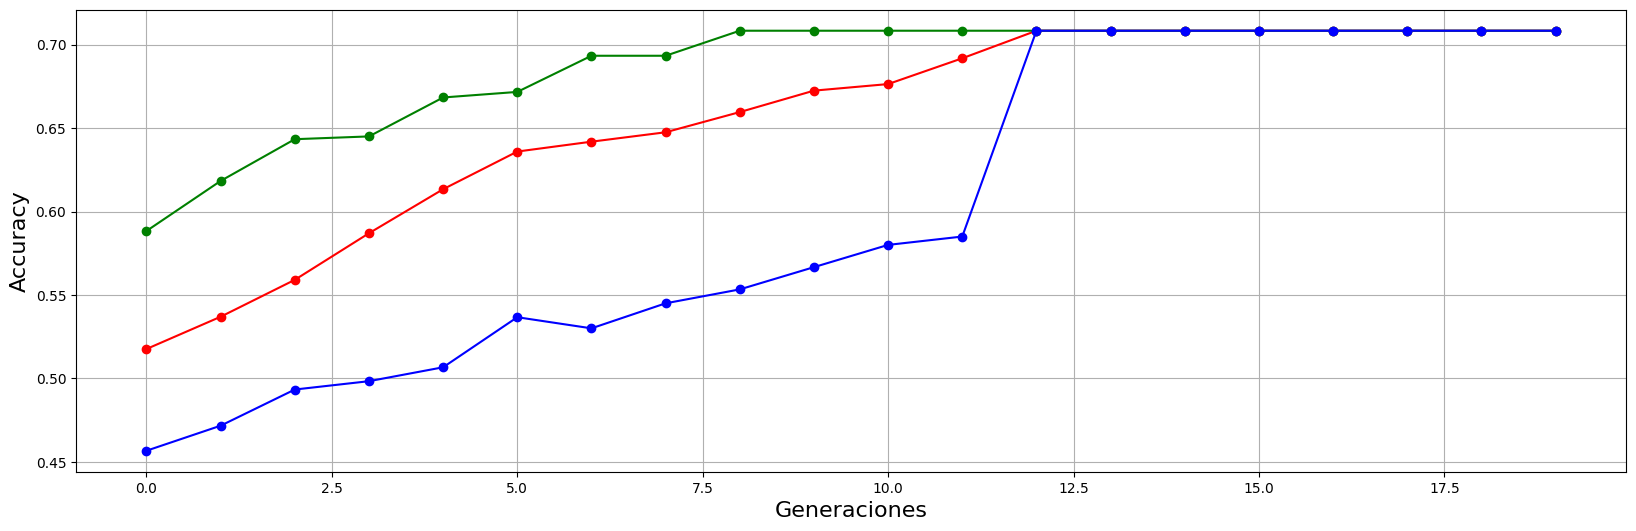

In [22]:
f_avg = logbook.chapters['acc'].select('avg')  # Extraemos fitness promedio a lo largo de las épocas
f_max = logbook.chapters['acc'].select('max')  # Extraemos fitness máximo a lo largo de las épocas
f_min = logbook.chapters['acc'].select('min')  # Extraemos fitness mínimo (elite) a lo largo de las épocas

N = 30 if GMAX > 200 else GMAX 
fig, ax = plt.subplots(1, 1, figsize=(20,6)) 
ax.plot(range(N), f_avg[:N], '-or')
ax.plot(range(N), f_max[:N], '-og')
ax.plot(range(N), f_min[:N], '-ob')
ax.set_xlabel('Generaciones', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=16)
ax.grid(True)

## Graficamos la evolución del número de genes

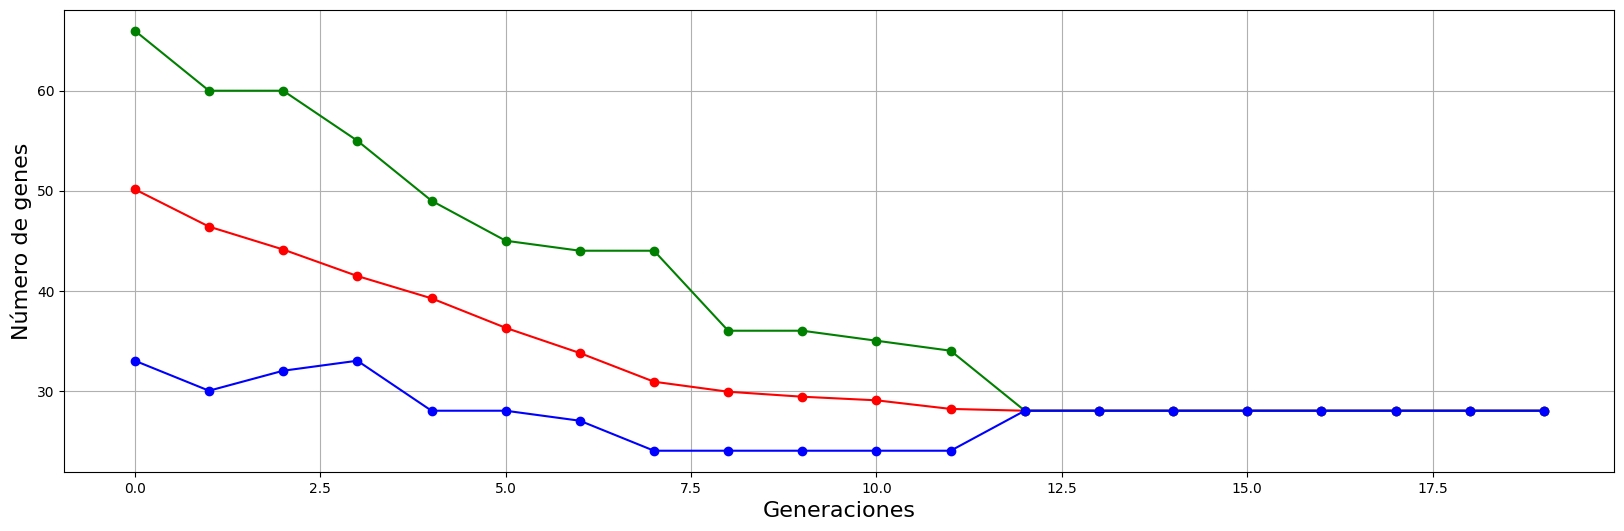

In [23]:
ngenes_avg = logbook.chapters['ngenes'].select('avg')  # Extraemos fitness promedio a lo largo de las épocas
ngenes_max = logbook.chapters['ngenes'].select('max')  # Extraemos fitness máximo a lo largo de las épocas
ngenes_min = logbook.chapters['ngenes'].select('min')  # Extraemos fitness mínimo (elite) a lo largo de las épocas

N = 100 if GMAX > 2000 else GMAX 
fig, ax = plt.subplots(1, 1, figsize=(20,6)) 
ax.plot(range(N), ngenes_avg[:N], '-or')
ax.plot(range(N), ngenes_max[:N], '-og')
ax.plot(range(N), ngenes_min[:N], '-ob')
ax.set_xlabel('Generaciones', fontsize=16)
ax.set_ylabel('Número de genes', fontsize=16)
ax.grid(True)